# Training a saliency prediction network

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, [Dublin City University](https://www.dcu.ie/)

[Insight Centre for Data Analytics](https://www.insight-centre.org/)

---

This lab will illustrate how to specify and train a visual saliency prediction network. We will use a modified [U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/), and train on a downsampled version of the [SALICON](http://salicon.net/) dataset.

## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

## Enable GPU acceleration

Open to the Edit menu and select *Notebook settings* and then select *GPU* under hardware accelerator.

Change the line below to ``device = 'cpu'`` to run on the CPU instead.

In [ ]:
device = 'cuda'

## Imports


Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import os
import itertools

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import gdown

from torchvision.datasets.utils import list_dir, list_files
from torchvision.datasets.folder import pil_loader
from torchvision.datasets.utils import download_file_from_google_drive
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from google.colab import widgets

## Dataset download

Mini-SALICON is a downsampled version of the [SALICON](http://salicon.net/) dataset that I created to be compact enough (~140MB) for demonstration purposes. You can download it using tyis [Google Drive link](https://drive.google.com/file/d/19X4y27WGZY4iO3p2bd38l46lD9uW72mU/view?usp=sharing). Here I use a utility function from PyTorch for downloading from Google Drive.

In [ ]:
#download_file_from_google_drive('19X4y27WGZY4iO3p2bd38l46lD9uW72mU', 'data', 'salicon-mini.tar')

In [ ]:
gdown.download(id='19X4y27WGZY4iO3p2bd38l46lD9uW72mU',output='salicon-mini.tar')

Downloading...
From: https://drive.google.com/uc?id=19X4y27WGZY4iO3p2bd38l46lD9uW72mU
To: /content/salicon-mini.tar
100%|██████████| 148M/148M [00:02<00:00, 56.4MB/s]


'salicon-mini.tar'

Extract the tar file

In [ ]:
!pwd

/content


In [ ]:
!ls -l

total 144332
drwxr-xr-x 2 root root      4096 Apr 24 10:04 checkpoints
drwxrwxr-x 5 1000 1000      4096 Jun 19  2019 salicon-mini
-rw-r--r-- 1 root root 147783680 Apr 24 10:23 salicon-mini.tar
drwxr-xr-x 1 root root      4096 Apr 19 14:23 sample_data


In [ ]:
 !tar xf salicon-mini.tar #!cd content &&

Clean up

In [ ]:
!rm /content/salicon-mini.tar

In [ ]:
!ls /content/salicon-mini

make.py  train	valid


In [ ]:
!mkdir -p checkpoints

## Dataset class

We define a dataset class following the standard pattern used in PyTorch. The `__getitem__` method returns an (image, saliency map) pair.

In [ ]:
class SaliconMini(Dataset):
    def __init__(self, 
                 root='/content/salicon-mini', 
                 subset='train', 
                 im_transform=None, 
                 sm_transform=None,
                 loader=pil_loader):
        self.root = root
        self.im_transform = im_transform
        self.sm_transform = sm_transform
        self.loader = loader

        # locate the subset
        self.subdir = os.path.join(self.root, subset)

        # the image and saliency map subfolders
        self.im_dir = os.path.join(self.subdir, 'im')
        self.sm_dir = os.path.join(self.subdir, 'sm')

        # list the images in the image folder
        self.file_list = list_files(self.im_dir, '.jpg', prefix=False)
        self.file_list.sort()
            
    def __getitem__(self, index):

        # get the image and saliency map filenames
        im_filename = self.file_list[index]
        sm_filename = im_filename[:-4] + '.png'

        # get the full image path
        im_filename = os.path.join(self.im_dir, im_filename)

        # get the full saliency map path
        sm_filename = os.path.join(self.sm_dir, sm_filename)

        # load the image
        im = self.loader(im_filename)

        # load the saliency map
        sm = self.loader(sm_filename)

        # apply image transform if specified
        if self.im_transform is not None:
            im = self.im_transform(im)

        # apply saliency map transform if specified
        if self.sm_transform is not None:
            sm = self.sm_transform(sm)

        return im, sm
    
    def __len__(self):
        # return the number of entries in the dataset
        return len(self.file_list)


## Model architecture

This is a version of the popular U-Net architecure by [Olaf Ronneberger, Philipp Fischer, Thomas Brox](https://arxiv.org/abs/1505.04597). The architecure was originally developed for medical image segmentation but has been found to be suited to a variety of tasks. The skip connections help both with achieving good spatial detail and avoiding gradient vanishing.


![UNet architecure](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Here we repurpose the network for saliency detection. The output layer is a single channel sigmoid the same size as the input layer.


In [ ]:

class SalUNet(nn.Module):
    def __init__(self):
        super(SalUNet, self).__init__()

        # resolution: 128 x 96
        self.conv1_e1 = ConvAct(3, 64)
        self.conv1_e2 = ConvAct(64, 64)
        self.down1 = nn.MaxPool2d(2, 2)

        # resolution: 64 x 48
        self.conv2_e1 = ConvAct(64, 128)
        self.conv2_e2 = ConvAct(128, 128)
        self.down2 = nn.MaxPool2d(2, 2)
        
        # resolution: 32 x 24
        self.conv3_e1 = ConvAct(128, 256)
        self.conv3_e2 = ConvAct(256, 256)
        self.down3 = nn.MaxPool2d(2, 2)
        
        # resolution: 16 x 12
        self.conv4_e1 = ConvAct(256, 512)
        self.conv4_e2 = ConvAct(512, 512)
        self.down4 = nn.MaxPool2d(2, 2)

        # resolution: 8 x 6
        self.conv5_1 = ConvAct(512, 1024)
        self.conv5_2 = ConvAct(1024, 1024)
        
        # resolution: 16 x 12
        self.up4 = nn.ConvTranspose2d(1024, 512, 3, 2, 1, 1)
        self.conv4_d1 = ConvAct(1024, 512)
        self.conv4_d2 = ConvAct(512, 512)

        # resolution: 32 x 24
        self.up3 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.conv3_d1 = ConvAct(512, 256)
        self.conv3_d2 = ConvAct(256, 256)

        # resolution: 64 x 48
        self.up2 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.conv2_d1 = ConvAct(256, 128)
        self.conv2_d2 = ConvAct(128, 128)

        # resolution: 128 x 96
        self.up1 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.conv1_d1 = ConvAct(128, 64)
        self.conv1_d2 = ConvAct(64, 64)

        self.output_layer = ConvAct(64, 1, 1, activation='sigmoid')

    def forward(self, x):
        
        # level 1 - encode
        x = self.conv1_e1(x)
        x = out1 = self.conv1_e2(x)
        x = self.down1(x)

        # level 2 - encode
        x = self.conv2_e1(x)
        x = out2 = self.conv2_e2(x)
        x = self.down2(x)

        # level 3 - encode
        x = self.conv3_e1(x)
        x = out3 = self.conv3_e2(x)
        x = self.down3(x)

        # level 4 - encode
        x = self.conv4_e1(x)
        x = out4 = self.conv4_e2(x)
        x = self.down4(x)

        # level 5 - encode/decode
        x = self.conv5_1(x)
        x = self.conv5_2(x)

        # level 4 - decode
        x = self.up4(x)
        x = torch.cat((x, out4), dim=1)
        x = self.conv4_d1(x)
        x = self.conv4_d2(x)

        # level 3 - decode
        x = self.up3(x)
        x = torch.cat((x, out3), dim=1)
        x = self.conv3_d1(x)
        x = self.conv3_d2(x)

        # level 2 - decode
        x = self.up2(x)
        x = torch.cat((x, out2), dim=1)
        x = self.conv2_d1(x)
        x = self.conv2_d2(x)

        # level 1 - decode
        x = self.up1(x)
        x = torch.cat((x, out1), dim=1)
        x = self.conv1_d1(x)
        x = self.conv1_d2(x)

        # make predictions
        x = self.output_layer(x)
        return x
    

_named_activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'prelu': nn.PReLU,
    'leakyrelu': nn.LeakyReLU,
    'elu': nn.ELU
}


def same_padding(kernel, dilation):
    return int((kernel + (kernel - 1) * (dilation - 1) - 1) / 2)


def get_activation_by_name(name, **kwargs):
    return _named_activations[name](**kwargs)


class ConvAct(nn.Module):
    """Conv->Activation"""
    def __init__(
            self, in_channels, out_channels,
            kernel=3, dilation=1, activation='relu'):
        super(ConvAct, self).__init__()
        padding = same_padding(kernel, dilation)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel,
            padding=padding,
            dilation=dilation)
        self.activation = get_activation_by_name(activation)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        return self.activation(self.conv(x))

## Utilities

Usually when training a deep learning model, you want to keep track of the loss. However, the **loss on individual batches is quite noisy**, so I usually use an **exponentially decayed moving average** to smooth out individual fluctuations in each batch and make general trends more easy to see. 

At validation time you usually want to find the average loss over the full dataset, so a running average (cumulative moving average) is more appropriate.

Here we define two classes to take care of this.

In [ ]:
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value

## Create datasets and loaders

Here we don't do any random horizontal flips becasue we would need to be careful to apply the same flip to the saliency map. It would be a nice exercise to modify the data loaders to incorporate this functionality. 

In [ ]:
im_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

sm_tf = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

# create training and validation datasets
train_set = SaliconMini(subset='train', im_transform=im_tf, sm_transform=sm_tf)
valid_set = SaliconMini(subset='valid', im_transform=im_tf, sm_transform=sm_tf)
print(len(train_set), len(valid_set))

9500 500


In [ ]:
# create a data loader with a batch size of 16 and shuffle enabled
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, pin_memory=True)

# create a validation loader with smaller batch size (10) and shuffle disabled
valid_loader = DataLoader(valid_set, batch_size=10, shuffle=False, pin_memory=True)

## Instantiate model

Create an instance of the model and move it (memory and operations) to the CUDA device.

In [ ]:
# instantiate our model and move it to the GPU
model = SalUNet()
model.to(device);

## Setup objective and optimizer

The saliency prediction model essentially outputs a probability for each pixel that it will be attended to. The total **binary cross entropy** is an appropriate loss function to use here.

We will use **Adam** as the optimizer with a learning rate of $10^{-4}$. SGD can probably do better than Adam in the long run, but Adam gets better results than SGD when the training time is restricted to a few epochs. Since we do not want to spend a very long time training in this lab, let's use Adam. See [Sebastian Ruder's excellent blog post](https://ruder.io/optimizing-gradient-descent/) for more information about Adam and other optimizers.

In [ ]:
# Create the optimization criterion (loss)
criterion = nn.BCELoss()

# Create an Adam optimizer with learning rate of 0.0001
optimizer = optim.Adam(model.parameters(),lr=1e-4)

## Checkpointing

The following helpers functions are used for loading and saving snapshots of the model.

In [ ]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

## Train helpers

Here we define some helper functions abstract some of the training. Many of these are defined as Python generators, which makes it easy to do something with the loss at the end of each iteration.

In [ ]:
def train_for_epoch(loader, model, optimizer, criterion):
    n_steps = len(train_loader)    
    
    # put the model in train mode
    model.train()

    # iterate over batches
    for step, (batch, targets) in enumerate(loader):

        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions,targets)

        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()
        
        yield step, n_steps, float(loss)
        

def validate(loader, model, optimizer, criterion):
    
    # put the model in eval mode
    model.eval()
    
    # use a running average to keep track of the average loss
    valid_loss = RunningAverage(count=len(loader))
    
    # We don't need gradients for validation, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
    
        for step, (batch, targets) in enumerate(loader):
            # Move the training batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            valid_loss.update(loss)
    
    return valid_loss.value
        

def monitor_progress(train_generator):
    start_time = time.time()
    for step, n_steps, loss in train_generator:
        elapsed = int(time.time() - start_time)
        print(f'\rBatch {step+1:03d}/{n_steps}  loss: {loss:0.4f}  elapsed: {elapsed}s',
              end='', flush=True)
    print()
    yield step, n_steps, loss
        
        
def track_running_average_loss(train_generator):
    average_loss = MovingAverage()
    for step, n_steps, loss in train_generator:
        average_loss.update(loss)
        yield step, n_steps, average_loss.value
        
        
def run_train_generator(train_generator):
    for step, n_steps, loss in train_generator:
        pass
    return loss
    
    
def show_examples(dataset, model, count=5, size=(3.3, 2.5)):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # same mean and standard deviation that were applied in the transform
    pix_mean = torch.as_tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32, device=device)
    pix_std = torch.as_tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32, device=device)
    
    # put model in eval mode
    model.eval()
    
    # create a colab grid
    grid = widgets.Grid(3, count)
    
    with torch.no_grad():
        for i, (batch, targets) in enumerate(itertools.islice(loader, count)):
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            # unnormalize image
            image = batch[0].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])
            image.clamp_(0,1)
            
            # convert to PIL images
            image = tF.to_pil_image(image.cpu())
            target = tF.to_pil_image(targets.cpu()[0,0])
            y_pred = tF.to_pil_image(predictions.cpu()[0,0])
            
            # display
            with grid.output_to(0,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(image)
            with grid.output_to(1,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(target)
            with grid.output_to(2,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.imshow(y_pred)

               

## Train the model
First, let's define a function that uses the above utilities to train the model for a specified number of epochs.
Note: we are training **from scratch**: no pre-trained weights from imagenet are used here!

In [ ]:
def train(first_epoch, n_epochs):

    # keep track of losses
    train_losses, valid_losses = [], []

    for epoch in range(first_epoch, n_epochs + first_epoch):

        # train
        train_generator = train_for_epoch(train_loader, model, optimizer, criterion)
        train_generator = track_running_average_loss(train_generator)
        train_generator = monitor_progress(train_generator)
        train_loss = run_train_generator(train_generator)
        train_losses.append(train_loss)

        # validate
        valid_loss = validate(valid_loader, model, optimizer, criterion)
        valid_losses.append(valid_loss)
        print('Epoch {} validation loss: {:.5f}'.format(epoch, valid_loss))

        # Save a checkpoint
        checkpoint_filename = 'checkpoints/salunet-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
   
    return train_losses, valid_losses

Time to train the model. Each epoch here takes around between 1 and 4 minutes depending on the GPU you are allocated.

In [ ]:
train_losses, valid_losses = train(first_epoch=1, n_epochs=5)

Batch 594/594  loss: 0.3182  elapsed: 304s
Epoch 1 validation loss: 0.15635
Batch 594/594  loss: 0.3091  elapsed: 301s
Epoch 2 validation loss: 0.15228
Batch 594/594  loss: 0.3008  elapsed: 302s
Epoch 3 validation loss: 0.15123
Batch 594/594  loss: 0.3012  elapsed: 304s
Epoch 4 validation loss: 0.14812
Batch 594/594  loss: 0.2949  elapsed: 305s
Epoch 5 validation loss: 0.14728


## Show some examples

Display some examples from the validation set. The top row shows the image, the middle row is the ground truth, and the bottom row is the predicted saliency map.

,,,,
,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

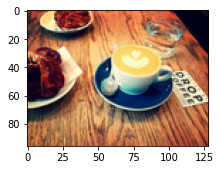

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

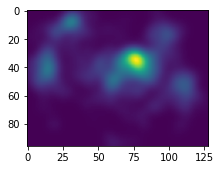

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

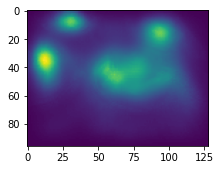

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

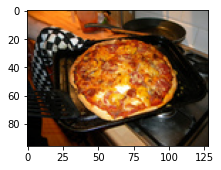

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

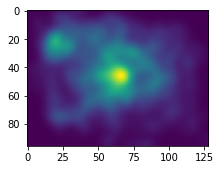

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

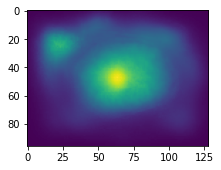

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

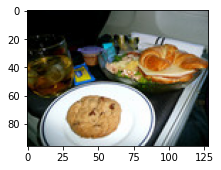

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

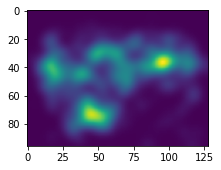

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

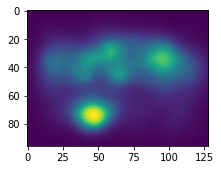

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

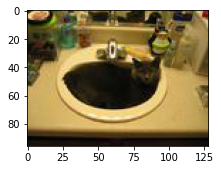

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

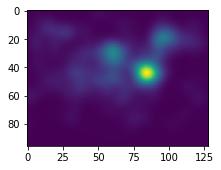

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

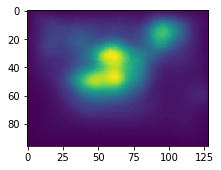

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

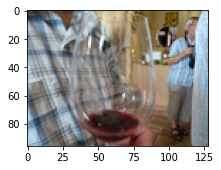

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

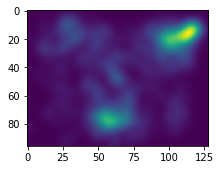

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

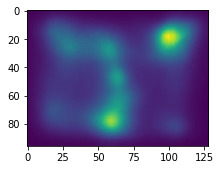

<IPython.core.display.Javascript object>

In [ ]:
show_examples(valid_set, model)

## Train for longer

Looks like we've started to learn to predict visual saliency! Training for another few epochs can improve the model. Let's train for another 5 epochs.

In [ ]:
train_losses, valid_losses = train(first_epoch=6, n_epochs=5)

Batch 594/594  loss: 0.2966  elapsed: 306s
Epoch 6 validation loss: 0.14696
Batch 594/594  loss: 0.2932  elapsed: 306s
Epoch 7 validation loss: 0.14665
Batch 594/594  loss: 0.2914  elapsed: 306s
Epoch 8 validation loss: 0.14702
Batch 594/594  loss: 0.2896  elapsed: 306s
Epoch 9 validation loss: 0.14597
Batch 594/594  loss: 0.2859  elapsed: 306s
Epoch 10 validation loss: 0.14642


And show some examples from the validation set:

,,,,
,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

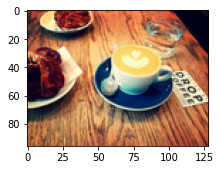

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

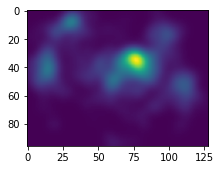

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

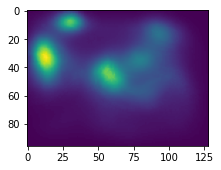

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

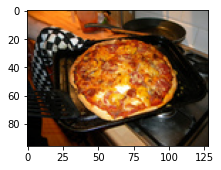

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

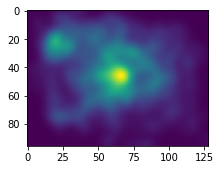

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

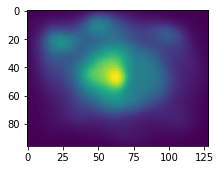

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

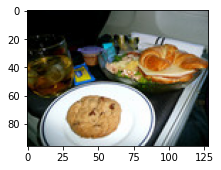

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

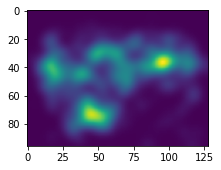

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

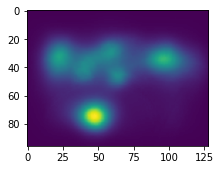

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

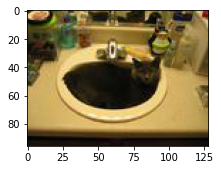

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

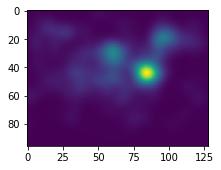

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

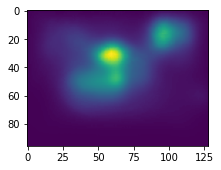

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

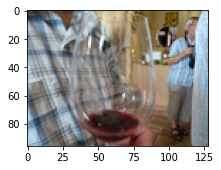

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

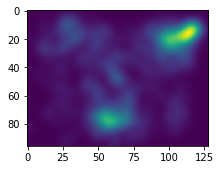

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

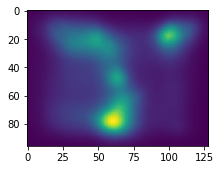

<IPython.core.display.Javascript object>

In [ ]:
show_examples(valid_set, model)

Notice how the predictions are a little smoother and more focused than before.